This notebook includes all of the code for the experients and analyses.  It uses a python v3 and tensorflow v1.14 port of the SEM model, and should run as is in Colab.  

I've hidden most of the code except for the relevant parameters to switch between Blocked > Interleaved and Interleaved > Blocked.  Hopefully the plots are clear, but let me know if they are not.



In [1]:
import sys
print("Python version")
print (sys.version)

Python version
3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]


## Load Libraries

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tqdm import tqdm
from sklearn import metrics
import pandas as pd

from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from scipy.special import logsumexp
from scipy.stats import norm
from glob import glob


#this code just allows us to add the custom code 
# import sys, os

# current_path = os.path.abspath('.')
# parent_path = os.path.dirname(current_path)
# sys.path.append(parent_path)

from schema_prediction_task_9_8_20 import generate_exp, batch_exp


TensorFlow Version: 2.3.1


## Story Parameters

In [3]:
seed = None
err = 0.2; # error probability for plate's formula

# story_generator = generate_exp_balanced
story_kwargs = dict(seed=seed, err=err, actor_weight=1.0, instructions_weight=1.0)


x, y, e, embedding_library = generate_exp('blocked', **story_kwargs)
d = np.shape(x)[-1]
d

10

<AxesSubplot:>

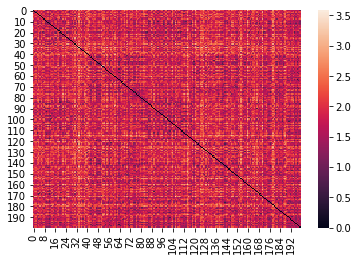

In [4]:
from sklearn.metrics.pairwise import euclidean_distances

story_kwargs = dict(seed=seed, err=err, actor_weight=1.0, instructions_weight=0.0)
x, y, e, embedding_library = generate_exp('blocked', **story_kwargs)
d = euclidean_distances(np.reshape(x, (200, -1)))
sns.heatmap(d)

<AxesSubplot:>

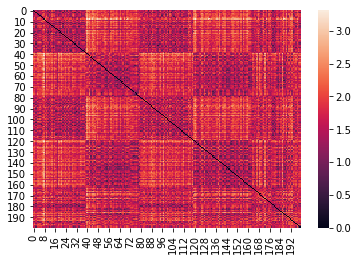

In [5]:
story_kwargs = dict(seed=seed, err=err, actor_weight=1.0, instructions_weight=1.0)
x, y, e, embedding_library = generate_exp('blocked', **story_kwargs)
d = euclidean_distances(np.reshape(x, (200, -1)))
sns.heatmap(d)

## SEM Parameters

In [6]:
from vanilla_lstm import VanillaLSTM
from sem.event_models import NonLinearEvent


## sem parameters
dropout           = 0.0  # don't change
l2_regularization = 0.0  # don't change
n_epochs          = 2
batch_size        = 25   # don't change
lr                = 0.05
epsilon           = 1e-5 # don't change
log_alpha         = 0.0  # sCRP alpha is set in log scale
log_lambda        = 0.0   # sCRP lambda is set in log scale
n_hidden          = None # don't change -- set the number of hidden units equal to the dimensionality
batch_update      = False # batch update (True) or local gradient updating (False)


# ADAM parameters, don't change
optimizer_kwargs = dict(
    lr=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon, amsgrad=False
)

# set the event model class
f_class = VanillaLSTM
# f_class = NonLinearEvent  # This is the multilayer perceptron

# the dictionaries below are used to pass the above parameters to SEM
f_opts=dict(
    dropout=dropout, batch_size=batch_size,batch_update=batch_update,
    l2_regularization=l2_regularization, n_epochs=n_epochs,
    optimizer_kwargs=optimizer_kwargs)

sem_kwargs = dict(lmda=np.exp(log_lambda), alfa=np.exp(log_alpha), f_opts=f_opts, f_class=f_class)




# Run model

The main script we use to run the experiment is  `schema_prediction_task_9_8_20.batch_exp`.  It's a wrapper function for a lot of code,
but it will generate a set of randomly sampled tasks of the specified conditions (default = Blocked, Interleaved), run the model (either SEM or a "no_split" variant of SEM that collapses to the NN specified) and calculate the meaningful metrics of the task.


It's desined to be a parallelizable job on a cluster -- you can pass a set of parameters to the function and get a pair of files as an output that represents a random sample of behavior for those parameters on the specified tasks.  I (NTF) would spawn thousands of instances of this function in seperate SLURM jobs, each with different parameters and write the results to file for grid-searches.  It is possible to get fancier with the paralization by writting a custom wrapper for some of the SEM module (look at the function `no_split_sem.no_split_sem_run_with_boundaries` for ideas) but I chose not to.

In [7]:
help(batch_exp)

Help on function batch_exp in module schema_prediction_task_9_8_20:

batch_exp(sem_kwargs, stories_kwargs, n_batch=8, n_train=160, n_test=40, progress_bar=True, sem_progress_bar=False, block_only=False, interleaved_only=False, run_mixed=False, debug=False, save_to_json=False, json_tag='', json_file_path='./', no_split=False, condensed_output=True, run_instructed=False, run_blocked_instructed=False)
    Function generates random tasks and runs the model on them.  Returns relevant performance 
    metrics, and can write these to file.
    
    
    :param sem_kwargs: (dictionary) specify the SEM parameters
    :param stories_kwargs: (dictionary) specify the parameters for the stories
    :param n_batches: (int, default=8), a batch is one each of sample of each condition specified
    :param n_train: (int, default=160)
    :param n_test: (int, default=40)
    :param progress_bar: (bool, default=True) show a progress bar for each batch/condition 
                        (just says "Run SEM

In [8]:
n_batch=1

no_split = False # toggle between SEM (False) and LSTM (True)

# for historical reasons, the results are returned a threeple, with 
# the last element as None
results, trialXtrial, _ = batch_exp(
    sem_kwargs, story_kwargs, n_batch=n_batch, sem_progress_bar=True, 
    progress_bar=False, block_only=False, run_instructed=False, no_split=no_split)


# the results are stored in JSON file format (here, a dictionary)
# and can be converted to pandas.DataFrames for convinience.
results = pd.DataFrame(results)
trialXtrial = pd.DataFrame(trialXtrial)

Run SEM: 100%|██████████| 200/200 [03:59<00:00,  1.20s/it]


# Analyses


This bar shows a Clustering score (adjusted mutual information) the evaluates on a scale of 0-1 (1 being the best score) well the model's estimate of each event type matches the true event type. 

In [9]:
results

,Trials,adjRand,nClusters,pe,pe (probes),verb decoder Accuracy,verb decoder Accuracy Prob,verb 2 AFC decoder Prob,batch,Condition,cluster re-use
0,All,0.051123,8,0.560728,0.559490,0.172500,0.152039,0.520235,0,Blocked,NaN
1,Training,0.059129,8,0.557078,0.563884,0.184375,0.152535,0.525401,0,Blocked,NaN
2,Test,0.080273,5,0.575331,0.541910,0.125000,0.150058,0.499568,0,Blocked,1.0
3,All,-0.000351,11,0.581321,0.605912,0.140000,0.130931,0.511184,0,Interleaved,NaN
4,Training,-0.000012,11,0.584197,0.610323,0.134375,0.127756,0.523192,0,Interleaved,NaN
5,Test,-0.031004,4,0.569819,0.588267,0.162500,0.143634,0.463151,0,Interleaved,1.0


In [10]:
trialXtrial

,t,e_hat,Accuracy,pe,batch,Condition
0,0,0,0.832703,0.829947,0,Blocked
1,1,1,0.547019,1.191653,0,Blocked
2,2,0,0.346283,0.653451,0,Blocked
3,3,0,0.484764,0.562009,0,Blocked
4,4,0,0.835646,0.550477,0,Blocked
...,...,...,...,...,...,...
395,195,0,0.039448,0.702733,0,Interleaved
396,196,4,0.884501,0.498747,0,Interleaved
397,197,4,0.000572,0.693389,0,Interleaved
398,198,6,0.000650,0.666814,0,Interleaved
